# Extra Exercise: Small Shifts CC

The concentration of a chemical compound is consecutively measured for 20 samples and stored in `ESE03_extra.csv`.

1. Design a CUSUM chart by using 0.8% as an estimate of the standard deviation and 90% as target value. Is the process IC?
2. Five additional samples are collected (90.75, 91.00, 91.15, 90.95 and 91.86). Apply the designed control chart and determine if the process is IC or not. In the presence of OOCs, estimate the new process mean.

In [52]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qdatoolkit as qda

# Import the dataset
data = pd.read_csv('..\..\Dataset\concentration.csv')

# Inspect the dataset
data.head()

,concentration
0,89.11
1,90.59
2,91.03
3,89.46
4,89.78


Visualize the data.

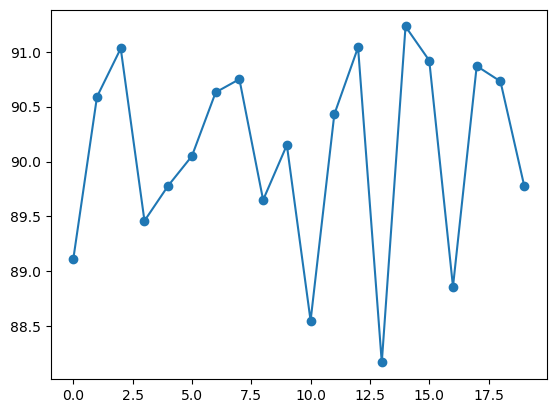

In [53]:
# plot the data
plt.plot(data,'o-')
plt.show()

Check if the data are random. 

Runs test statistic = 0.975
Runs test p-value = 0.329



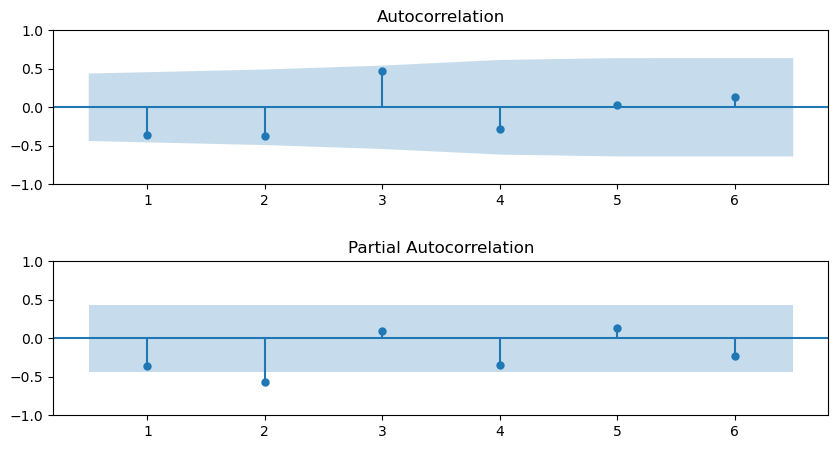

In [54]:
# Verify if the data are random with runs test
# Import the necessary libraries for the runs test

_ = qda.Assumptions(data['concentration']).independence()

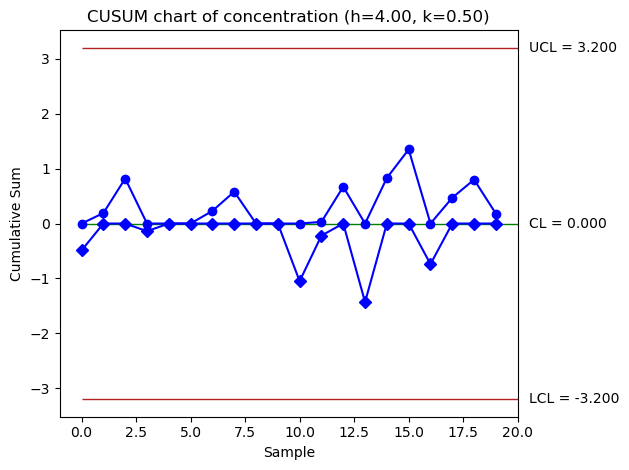

In [55]:
k = 0.5
h = 4

mu0 = 90
sigma0 = 0.8

# Design the CUSUM control chart
df_CUSUM = qda.ControlCharts.CUSUM(data, 'concentration', params=(h,k), mean = mu0, sigma_xbar = sigma0)

## Point 2
Five additional samples are collected (90.75, 91.00, 91.15, 90.95 and 91.86). Apply the designed control chart and determine if the process is IC or not. In the presence of OOCs, estimate the new process mean.

In [56]:
data_p2 = pd.DataFrame({'concentration': [90.75, 91.00, 91.15, 90.95, 91.86]})

# get the length of the phase 1 data
n = len(data)

# concatenate the two datasets
data = pd.concat([data, data_p2], ignore_index=True)

Use the previously designed CUSUM chart to analyze the new data.

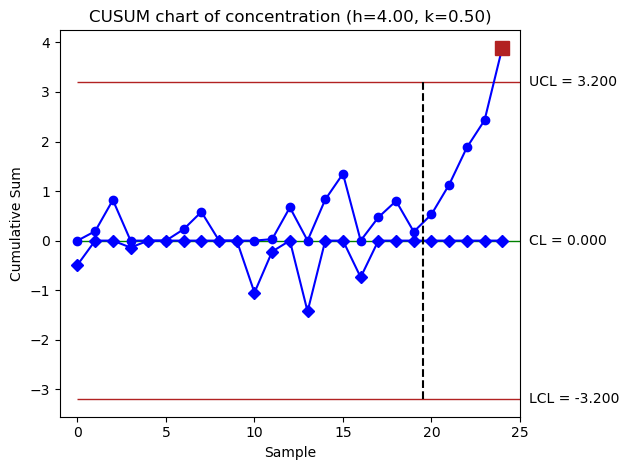

In [57]:
df_CUSUM = qda.ControlCharts.CUSUM(data, 'concentration', params=(h,k), mean = mu0, sigma_xbar = sigma0, subset_size=n)

The new estimated process mean is calculated by the following formula:
$$\hat{\mu} = \mu_0 + K + \frac{C_i^+}{N_h} = 90 + 0.8 \cdot \frac{1}{2} + \frac{3.89}{8} = 90.886$$

Where:
- $N_h$ is the number of consecutive non-zero values of the upper cumulator when the OOC is detected.

In [66]:
# Create a time series Nh that is 0 when Ci+ is 0 and increases by 1 for every consecutive Ci+ > 0
Nh = pd.Series(0, index=df_CUSUM.index)
counter = 0

for idx in df_CUSUM.index:
    if df_CUSUM.loc[idx, 'Ci+'] > 0:
        # If Ci+ is positive, increment the counter
        counter += 1
        Nh[idx] = counter
    else:
        # If Ci+ is 0, reset the counter to 0
        counter = 0
        Nh[idx] = 0

# Add Nh+ column to the CUSUM dataframe
df_CUSUM['Nh+'] = Nh

# Compute the control limit and get the index of the first out of control point
H = h*sigma0
print('H = {}'.format(H))

first_out_of_control = df_CUSUM[df_CUSUM['Ci+'] > H].index[0]
print('The first out of control point is at index:', first_out_of_control)

# Get the value of Nhs
Nh = df_CUSUM['Nh+'].iloc[first_out_of_control]
print('N_h = {}'.format(Nh))

# Get the value of K
k = 0.5
K = k * sigma0
print('K = {}'.format(K))

# Get the cusum value at the first OOC sample
print('C+_i = {}'.format(df_CUSUM['Ci+'].iloc[first_out_of_control]))

# Calculate the estimated mean
mu_hat = mu0 + K + df_CUSUM['Ci+'].iloc[first_out_of_control] / Nh
print('mu_hat = {}'.format(mu_hat))


H = 3.2
The first out of control point is at index: 24
N_h = 8
K = 0.4
C+_i = 3.889999999999972
mu_hat = 90.88625


# Extra Exercise: Attributes CC

To establish the control chart, 30 samples of n = 50 cans each were selected at half-hour intervals over a three-shift period in which the machine was in continuous operation. The data are in the file “Cans.csv”.

Design a p-chart using this data to determine if the process was in control when these data were collected.



In [59]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import qdatoolkit as qda

# Import the dataset
df = pd.read_csv('..\..\dataset\Cans.csv')

# Inspect the dataset
df.head()

,NonConforming,Tot
0,12,50
1,15,50
2,8,50
3,10,50
4,4,50


In [60]:
df['prop'] = df['NonConforming'] / df['Tot']
p_bar = df['NonConforming'].sum() / df['Tot'].sum()

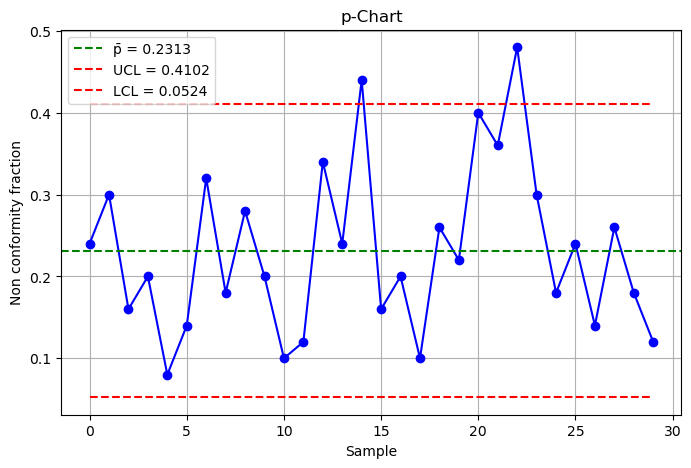

In [61]:
# Control Limits
df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Tot'])
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Tot'])
df['LCL'] = df['LCL'].apply(lambda x: max(x, 0))

plt.figure(figsize=(8, 5))
plt.plot(df.index, df['prop'], marker='o', linestyle='-', color='b')
plt.axhline(p_bar, color='green', linestyle='--', 
            label=f'p̄ = {p_bar:.4f}')
plt.plot(df.index, df['UCL'], linestyle='--', color='red', 
         label=f'UCL = {df["UCL"].mean():.4f}')
plt.plot(df.index, df['LCL'], linestyle='--', color='red', 
         label=f'LCL = {df["LCL"].mean():.4f}')

plt.title('p-Chart')
plt.xlabel('Sample')
plt.ylabel('Non conformity fraction')
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.grid(True)
plt.show()

Test Failed at points:  14, 22.
These points must beinvestigated to see whether an assignable cause can be determined.

It is discovered that the data from sample 15 indicates that a new batch of cardboard stock was put into production during that half-hour period. The introduction of new batches of raw material sometimes causes irregular production performance, and it is reasonable to believe that this has occurred here. 
Furthermore, during the half-hour period in which sample 23 was obtained, a relatively inexperienced operator had been temporarily assigned to the machine. 

Consequently, ooc samples are eliminated, and the revised control limits are calculated:


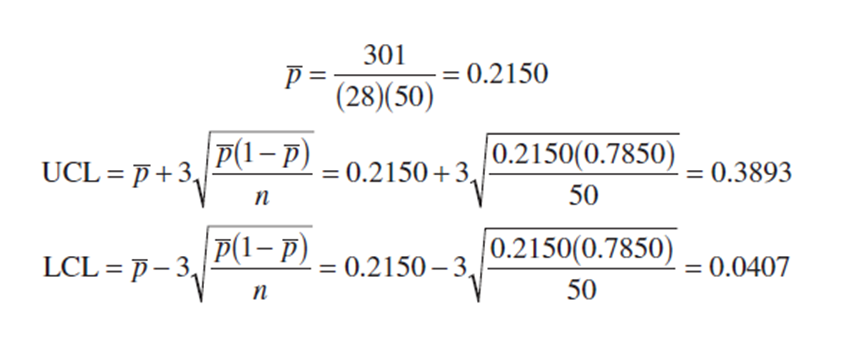

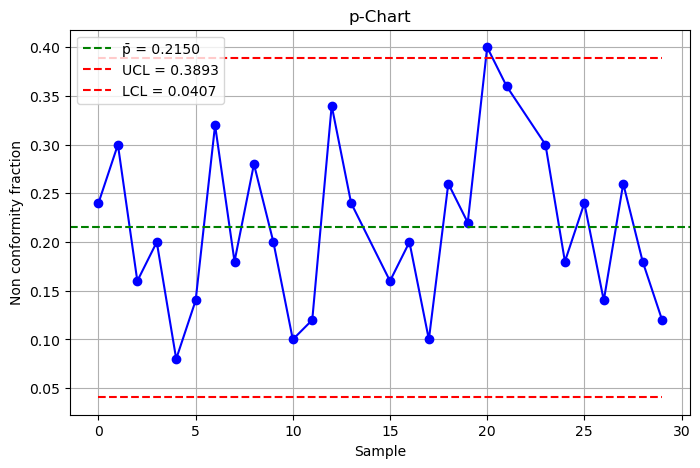

In [62]:
# Drop ooc with assignable cause:
df = df.drop([14, 22], errors='ignore') 

# Recompute the control limits:
df['prop'] = df['NonConforming'] / df['Tot']
p_bar = df['NonConforming'].sum() / df['Tot'].sum()

df['LCL'] = p_bar - 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Tot'])
df['UCL'] = p_bar + 3 * np.sqrt((p_bar * (1 - p_bar)) / df['Tot'])
df['LCL'] = df['LCL'].apply(lambda x: max(x, 0))

plt.figure(figsize=(8, 5))
plt.plot(df.index, df['prop'], marker='o', linestyle='-', color='b')
plt.axhline(p_bar, color='green', linestyle='--', 
            label=f'p̄ = {p_bar:.4f}')
plt.plot(df.index, df['UCL'], linestyle='--', color='red', 
         label=f'UCL = {df["UCL"].mean():.4f}')
plt.plot(df.index, df['LCL'], linestyle='--', color='red', 
         label=f'LCL = {df["LCL"].mean():.4f}')

plt.title('p-Chart')
plt.xlabel('Sample')
plt.ylabel('Non conformity fraction')
plt.legend(loc='upper left', fontsize=10, frameon=True)
plt.grid(True)
plt.show()

Note that sample 21 now exceeds the upper control limit. However, analysis of the data does not produce any reasonable or logical assignable cause for this, and we decide to retain the point.
Therefore, we conclude now that the new control limits can be used for future samples
